In [46]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt, ConditionalMomentsModel
from parsmooth.linearization import extended, unscented, cubature, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearing_data_pe import get_data, make_parameters, inverse_bearings
jax.config.update('jax_platform_name', 'cpu')

In [2]:
def nonlinear_function(x):
    return (x**3 + 1)/ (x**2 + 3) + jnp.sin(x)


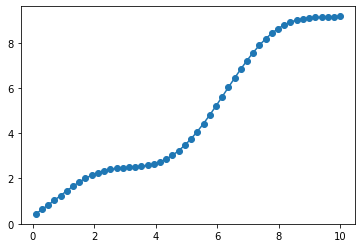

In [3]:
t = jnp.linspace(0.1,10)
plt.plot(t, nonlinear_function(t),'o-')

In [42]:
t

DeviceArray([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,
              0.90816327,  1.11020408,  1.3122449 ,  1.51428571,
              1.71632653,  1.91836735,  2.12040816,  2.32244898,
              2.5244898 ,  2.72653061,  2.92857143,  3.13061224,
              3.33265306,  3.53469388,  3.73673469,  3.93877551,
              4.14081633,  4.34285714,  4.54489796,  4.74693878,
              4.94897959,  5.15102041,  5.35306122,  5.55510204,
              5.75714286,  5.95918367,  6.16122449,  6.36326531,
              6.56530612,  6.76734694,  6.96938776,  7.17142857,
              7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
              8.18163265,  8.38367347,  8.58571429,  8.7877551 ,
              8.98979592,  9.19183673,  9.39387755,  9.59591837,
              9.79795918, 10.        ], dtype=float64)

In [11]:
 np.random.rand(1, 1)

array([[0.67361432]])

In [43]:
m_q = 0*np.random.randn(1)
yhat_gauss_hermite = []
yhat_extended = []
yhat_cubature = []
yhat_unscented = []

delta = 0.1
for i in t:
    m_x = jnp.array([i])
    chol_x = 0.01 + 0*np.random.rand(1, 1)
    chol_x[np.triu_indices(1, 1)] = 0
    chol_q = np.random.rand(1, 1)
    chol_q[np.triu_indices(1, 1)] = 0
    x = MVNStandard(m_x, chol_x @ chol_x.T)
    functional_model  = FunctionalModel(nonlinear_function, MVNStandard(m_q, chol_q @ chol_q.T))
    F_gauss_hermite, _, b_gauss_hermite = gauss_hermite(functional_model, x)
    F_extended, _, b_extended = extended(functional_model, x)
    F_cubature, _, b_cubature = cubature(functional_model, x)
    F_unscented, _, b_unscented = unscented(functional_model, x)
    yhat_gauss_hermite.append((F_gauss_hermite * (i+delta) + b_gauss_hermite)[0])
    yhat_extended.append((F_extended * (i+delta) + b_extended)[0])
    yhat_cubature.append((F_cubature * (i+delta) + b_cubature)[0])
    yhat_unscented.append((F_unscented * (i+delta) + b_unscented)[0])

    print('x:   ', i)
    print('F_gauss_hermite: ', F_gauss_hermite, 'b_gauss_hermite: ', b_gauss_hermite)
    print('F_cubature: ', F_cubature, 'b_cubature: ', b_cubature)
    print('F_extended: ', F_extended, 'b_extended: ', b_extended)
    print('F_unscented: ', F_unscented, 'b_unscented: ', b_unscented)

x:    0.1
F_gauss_hermite:  [[0.98292537]] b_gauss_hermite:  [0.33409303]
F_cubature:  [[0.98289116]] b_cubature:  [0.33409645]
F_extended:  [[0.98287406]] b_extended:  [0.33410415]
F_unscented:  [[0.98295957]] b_unscented:  [0.33408961]
x:    0.30204081632653057
F_gauss_hermite:  [[0.97834526]] b_gauss_hermite:  [0.3343821]
F_cubature:  [[0.97832099]] b_cubature:  [0.33438944]
F_extended:  [[0.97830885]] b_extended:  [0.33438988]
F_unscented:  [[0.97836952]] b_unscented:  [0.33437477]
x:    0.5040816326530612
F_gauss_hermite:  [[1.00248049]] b_gauss_hermite:  [0.32434556]
F_cubature:  [[1.00247577]] b_cubature:  [0.32434794]
F_extended:  [[1.00247341]] b_extended:  [0.32434139]
F_unscented:  [[1.00248521]] b_unscented:  [0.32434318]
x:    0.7061224489795918
F_gauss_hermite:  [[1.03241163]] b_gauss_hermite:  [0.30634723]
F_cubature:  [[1.03242647]] b_cubature:  [0.30633675]
F_extended:  [[1.03243388]] b_extended:  [0.30632542]
F_unscented:  [[1.0323968]] b_unscented:  [0.30635769]
x:  

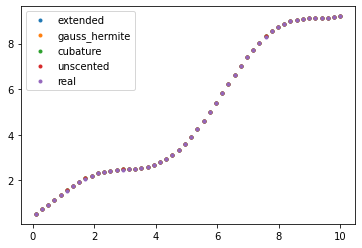

In [44]:
plt.plot(t,jnp.array(yhat_extended), '.')
plt.plot(t,jnp.array(yhat_gauss_hermite), '.')
plt.plot(t, jnp.array(yhat_cubature),'.')
plt.plot(t, jnp.array(yhat_unscented),'.')
plt.plot(t, nonlinear_function(t+delta),'.')
plt.legend(['extended','gauss_hermite','cubature', 'unscented', 'real'])


In [37]:
print('F_gauss_hermite: ', F_gauss_hermite, 'b_gauss_hermite: ', b_gauss_hermite)
print('F_cubature: ', F_cubature, 'b_cubature: ', b_cubature)
print('F_extended: ', F_extended, 'b_extended: ', b_extended)
print('F_unscented: ', F_unscented, 'b_unscented: ', b_unscented)

F_gauss_hermite:  [[0.18651483]] b_gauss_hermite:  [7.30930419]
F_cubature:  [[0.18648682]] b_cubature:  [7.30958424]
F_extended:  [[0.18647282]] b_extended:  [7.30969729]
F_unscented:  [[0.18654283]] b_unscented:  [7.30902414]


In [26]:
xhat = i

f = lambda x: nonlinear_function(x)
df = lambda x: (x**4+9*x**2-2*x)/((x**2+3)**2)+np.cos(x)
fl = lambda x: df(xhat)*(x-xhat) + f(xhat)

df(i)

DeviceArray(0.18647282, dtype=float64)

In [ ]:
f(0.21408163)

In [90]:
linearization_method = extended

s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05
T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)


positions = inverse_bearings(ys, s1, s2)
states = jnp.concatenate([jnp.concatenate([jnp.zeros((1,2)), positions], axis = 0),
                          jnp.zeros((T+1,3))], axis = 1)

initial_states =  MVNStandard(states,0.001*jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(states,jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))

R = jnp.diag(jnp.array([0.1 ** 2, 0.1 ** 2]))
observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))

In [91]:
m_q = 0*np.random.randn(1)
yhat_gauss_hermite = []
yhat_extended = []
yhat_cubature = []
yhat_unscented = []

delta = 0.1
for m_x, cov_x in zip(initial_states.mean,initial_states.cov):
    x = MVNStandard(m_x, cov_x)
    # functional_model  = FunctionalModel(nonlinear_function, MVNStandard(m_q, chol_q @ chol_q.T))
    F_gauss_hermite, _, b_gauss_hermite = gauss_hermite(observation_model, x)
    F_extended, _, b_extended = extended(observation_model, x)
    F_cubature, _, b_cubature = cubature(observation_model, x)
    F_unscented, _, b_unscented = unscented(observation_model, x)
    # yhat_gauss_hermite.append((F_gauss_hermite * (m_x+delta) + b_gauss_hermite)[0])
    # yhat_extended.append((F_extended * (m_x+delta) + b_extended)[0])
    # yhat_cubature.append((F_cubature * (m_x+delta) + b_cubature)[0])
    # yhat_unscented.append((F_unscented * (m_x+delta) + b_unscented)[0])

    print('x:   ', m_x)
    print('F_gauss_hermite: ', F_gauss_hermite, 'b_gauss_hermite: ', b_gauss_hermite)
    print('F_cubature: ', F_cubature, 'b_cubature: ', b_cubature)
    print('F_extended: ', F_extended, 'b_extended: ', b_extended)
    print('F_unscented: ', F_unscented, 'b_unscented: ', b_unscented)

x:    [0. 0. 0. 0. 0.]
F_gauss_hermite:  [[ 3.99999496e-01  8.00000473e-01  3.39871970e-17  3.39871970e-17
   8.57620859e-18]
 [ 5.00000149e-01 -5.00000149e-01 -2.54363004e-18 -4.23769593e-18
  -8.49564142e-19]] b_gauss_hermite:  [-0.46364761 -2.35619449]
F_cubature:  [[ 0.40117543  0.79978473  0.          0.          0.        ]
 [ 0.50041604 -0.50041604  0.          0.          0.        ]] b_cubature:  [-0.46364914 -2.35619449]
F_extended:  [[ 0.4  0.8  0.   0.   0. ]
 [ 0.5 -0.5  0.   0.   0. ]] b_extended:  [-0.46364761 -2.35619449]
F_unscented:  [[ 0.40306484  0.79943232  0.          0.          0.        ]
 [ 0.50107909 -0.50107909  0.          0.          0.        ]] b_unscented:  [-0.4636516  -2.35619449]
x:    [0.17312304 0.14949133 0.         0.         0.        ]
F_gauss_hermite:  [[ 2.33816358e-01  7.82565083e-01  3.79576639e-17  1.08526096e-17
   5.98217019e-18]
 [ 6.04445277e-01 -5.87650494e-01  4.80591936e-19  1.96289959e-18
  -2.90753985e-18]] b_gauss_hermite:  [-0.4

In [92]:
    print('F_gauss_hermite: ', F_gauss_hermite, 'b_gauss_hermite: ', b_gauss_hermite)
    print('F_cubature: ', F_cubature, 'b_cubature: ', b_cubature)
    print('F_extended: ', F_extended, 'b_extended: ', b_extended)
    print('F_unscented: ', F_unscented, 'b_unscented: ', b_unscented)

F_gauss_hermite:  [[ 1.09147371e-01  5.98396423e-01 -3.02814279e-17 -3.02814279e-17
   3.81164826e-18]
 [ 1.02124172e+00 -4.91574754e-01 -1.87935435e-18  1.50877744e-18
   2.77932686e-18]] b_gauss_hermite:  [-0.37046726 -2.54907993]
F_cubature:  [[ 0.10934103  0.59807527  0.          0.          0.        ]
 [ 1.02069327 -0.49394925  0.          0.          0.        ]] b_cubature:  [-0.3705212  -2.54825861]
F_extended:  [[ 0.10914745  0.59839648  0.          0.          0.        ]
 [ 1.02124029 -0.49157651  0.          0.          0.        ]] b_extended:  [-0.37046732 -2.54907869]
F_unscented:  [[ 0.10965212  0.59756239  0.          0.          0.        ]
 [ 1.01979445 -0.49777606  0.          0.          0.        ]] b_unscented:  [-0.37060846 -2.54692569]


In [93]:
F_gauss_hermite

DeviceArray([[ 1.09147371e-01,  5.98396423e-01, -3.02814279e-17,
              -3.02814279e-17,  3.81164826e-18],
             [ 1.02124172e+00, -4.91574754e-01, -1.87935435e-18,
               1.50877744e-18,  2.77932686e-18]], dtype=float64)

In [94]:
F_cubature

DeviceArray([[ 0.10934103,  0.59807527,  0.        ,  0.        ,
               0.        ],
             [ 1.02069327, -0.49394925,  0.        ,  0.        ,
               0.        ]], dtype=float64)

In [95]:
F_extended

DeviceArray([[ 0.10914745,  0.59839648,  0.        ,  0.        ,
               0.        ],
             [ 1.02124029, -0.49157651,  0.        ,  0.        ,
               0.        ]], dtype=float64)

In [96]:
F_unscented

DeviceArray([[ 0.10965212,  0.59756239,  0.        ,  0.        ,
               0.        ],
             [ 1.01979445, -0.49777606,  0.        ,  0.        ,
               0.        ]], dtype=float64)

In [55]:
for x, cov in zip(initial_states.mean,initial_states.cov):
    print(x.shape,cov.shape)


(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)
(5,) (5, 5)


In [73]:
Q.shape





(5, 5)

In [74]:
cov_x.shape

(5, 5)

In [75]:
cov_x

DeviceArray([[1., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0.],
             [0., 0., 1., 0., 0.],
             [0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1.]], dtype=float64)